<a href="https://colab.research.google.com/github/andreasschmidtjensen/facial-keypoints/blob/master/Facial_Keypoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoints Detection
I came across a blog post about detecting facial keypoints using CNNs and thought it would be fun to try as well. The blog post can be found [here](https://medium.com/datadriveninvestor/facial-key-point-detection-88ccfaeaf9ee). (Spoiler: I do many of the same things done in that, so don't expect any extraordinary findings here - I just wanted to experiment).

The project uses a dataset that contains over 7000 faces with labelled keypoints, ready to use.

## Getting the data
All of this is executed on Google Colab (also to try that out -  actually very nice!), so first, I had to get the datasets (available from Kaggle). The first parts uses a combination of Python and OS commands to download the dataset and unpackage it, so it can be loaded into the notebook.

In [1]:
!pip install kaggle
!mkdir -p .kaggle
!mkdir -p ~/.kaggle

import json
token = {"username":"andreas3","key":"<secret>""}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle config set -n path -v{/content}

- path is now set to: {/content}


We can list all available datasets about facial keypoints:

In [2]:
!kaggle datasets list -s facial-keypoints

ref                                                title                                     size  lastUpdated          downloadCount  
-------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  
selfishgene/youtube-faces-with-facial-keypoints    YouTube Faces With Facial Keypoints       10GB  2017-11-14 05:46:08           2236  
drgilermo/face-images-with-marked-landmark-points  Face Images with Marked Landmark Points  105MB  2017-09-19 18:39:17            923  
pcminers/fpoints                                   Facial keypoints                         314MB  2016-12-05 08:54:48            213  
sharwon/facialkeypointsdetectionimg                facial-keypoints-detection-img            18MB  2018-11-14 12:25:50             34  
parthgupta28/facial-keypoints-detection            Facial Keypoints Detection                76MB  2018-01-06 10:19:43             43  
petein/facialrecognition                        

We download a specific dataset and unzips the training and test-files.

In [3]:
!kaggle datasets download parthgupta28/facial-keypoints-detection -p /content

 98% 75.0M/76.3M [00:00<00:00, 55.8MB/s]
100% 76.3M/76.3M [00:00<00:00, 104MB/s] 


In [4]:
!unzip facial-keypoints-detection.zip

Archive:  facial-keypoints-detection.zip
  inflating: training.zip            
  inflating: test (8).zip            
  inflating: IdLookupTable.csv       
  inflating: SampleSubmission.csv    


In [5]:
!unzip training.zip
!unzip test\ \(8\).zip

Archive:  training.zip
  inflating: training.csv            
Archive:  test (8).zip
  inflating: test.csv                


In [8]:
import os
os.listdir("/content")

7050 /content/training.csv


## Exploration
We load the data into a Pandas dataframe and does some preprocessing. The images are part of the csv-file and can simply be converted into Numpy arrays for further processing.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import sklearn

In [0]:
data = pd.read_csv("/content/training.csv")
data = data.dropna()
data["Image"] = data["Image"].apply(lambda x: np.fromstring(x, sep=" "))

Get all the images into a single numpy array, for easier use when training and normalize both the images and labels to be between 0 and 1.

In [26]:
original_x = np.vstack(data["Image"].values)
original_x = original_x.reshape(-1, 96, 96, 1)
original_x /= 255

original_y = data[data.columns[:-1]].values
original_y /= 96

print(original_x.shape, original_y.shape)

(2140, 96, 96, 1) (2140, 30)


We create a small validation set, since the test-set does actually not contain labels (for submission on Kaggle). 

In [0]:
original_x, original_y = sklearn.utils.shuffle(original_x, original_y)

test_x, test_y = original_x[:500], original_y[:500]
original_x, original_y = original_x[500:], original_y[500:]

We can now show an example of an image including the keypoints.

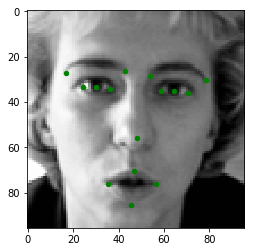

In [27]:
EXAMPLE_IDX = 1
image = original_x[EXAMPLE_IDX]
points = original_y[EXAMPLE_IDX] * 96  # de-normalize

%matplotlib inline
plt.imshow(np.squeeze(image), cmap="gray")
plt.scatter(points[0::2], points[1::2], marker='o', color='green', s=20)
        
plt.show()

## Creating more data
We only have 7000 datapoints for training, so we try to generate more training data by doing certain transformations. In this case, we do rotation and horizontal flip. Care must be taken to make sure that the coordinates of the keypoints are changed as well.

We can use features of OpenCV to create a rotation (and scaling) matrix, which can then be used for both rotating the image and adjusting the labels accordingly.

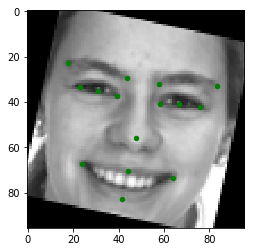

In [13]:
M = cv2.getRotationMatrix2D(center=(48, 48), angle=-12, scale=0.9)
dst = cv2.warpAffine(image, M, (96, 96))
new_points = np.zeros(len(points))

for i in range(15):
    coord = i * 2
    current = points[coord:coord+2]
    new = np.matmul(M, np.append(current, 1))
    new_points[coord] = new[0]
    new_points[coord+1] = new[1]

plt.imshow(np.squeeze(dst), cmap="gray")
plt.scatter(new_points[0::2], new_points[1::2], marker='o', color='green', s=20)
plt.show()

Flipping the image can actually be done using the Numpy [flip](https://docs.scipy.org/doc/numpy/reference/generated/numpy.flip.html) function. However, as stated on the documentation page, it is equivalent to using `::-1` which reverses the axis it is used on. 

This is not enough, though, because the labels refer to, e.g., the **left** and **right** eye, so we need to switch a few labels, so they point to the correct facial point.

In [15]:
image_flipped = image[:, ::-1, :]

flip_indices = [
    (0, 2), (1, 3),
    (4, 8), (5, 9), (6, 10), (7, 11),
    (12, 16), (13, 17), (14, 18), (15, 19),
    (22, 24), (23, 25),
    ]

for i, j in flip_indices:
    print("# {} -> {}".format(data.columns[i], data.columns[j]))

# left_eye_center_x -> right_eye_center_x
# left_eye_center_y -> right_eye_center_y
# left_eye_inner_corner_x -> right_eye_inner_corner_x
# left_eye_inner_corner_y -> right_eye_inner_corner_y
# left_eye_outer_corner_x -> right_eye_outer_corner_x
# left_eye_outer_corner_y -> right_eye_outer_corner_y
# left_eyebrow_inner_end_x -> right_eyebrow_inner_end_x
# left_eyebrow_inner_end_y -> right_eyebrow_inner_end_y
# left_eyebrow_outer_end_x -> right_eyebrow_outer_end_x
# left_eyebrow_outer_end_y -> right_eyebrow_outer_end_y
# mouth_left_corner_x -> mouth_right_corner_x
# mouth_left_corner_y -> mouth_right_corner_y


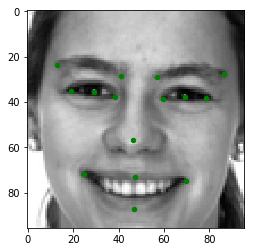

In [16]:
new_points = points.copy()
new_points[0::2] *= -1  # reverse labels
new_points[0::2] += 96  # move back into positive space

# switch based on the flip indices
for (i, j) in flip_indices:
    new_points[i], new_points[j] = new_points[j], new_points[i]

plt.imshow(np.squeeze(image_flipped), cmap="gray")
plt.scatter(new_points[0::2], new_points[1::2], marker='o', color='green', s=20)
        
plt.show()

Having shown that it works, we can build some functions to do the work. For rotating and scaling, we randomize the scale and angle, to make then system robust to different kinds of noise in the images.

In [0]:
def flip(data, labels):
    flip_data = np.copy(data)[:, :, ::-1, :]
    flip_labels = np.copy(labels)
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
    ]
    
    for i in range(flip_labels.shape[0]):
        flip_labels[i][0::2] *= -1  # flip
        flip_labels[i][0::2] += 1   # move back to positive (normalized between 0 and 1 now)
        
        for (x, y) in flip_indices:
            flip_labels[i][x], flip_labels[i][y] = flip_labels[i][y], flip_labels[i][x]
        
    return flip_data, flip_labels

In [0]:
def rotate_and_scale(data, labels):
    rotate_data = np.copy(data)
    rotate_labels = np.copy(labels)
        
    for j in range(rotate_labels.shape[0]):
        rotate_labels[j] *= 96
        
        angle = np.random.uniform(-1, 1) * 12
        scale = 1 + np.random.uniform(-1, 1) * 0.1
        
        # image
        M = cv2.getRotationMatrix2D(center=(48, 48), angle=angle, scale=scale)
        rotate_data[j] = np.expand_dims(cv2.warpAffine(np.squeeze(rotate_data[j]), M, (96, 96)), axis=2)
        
        # labels
        for i in range(15):
            coord = i * 2
            current = rotate_labels[j][coord:coord+2]
            new = np.matmul(M, np.append(current, 1))
            rotate_labels[j][coord] = new[0]
            rotate_labels[j][coord+1] = new[1]
        
        rotate_labels[j] /= 96
            
    return rotate_data, rotate_labels

We flip the images to double the training set and then we rotate and scale these images four times to get a large training set of almost 30.000 examples.

In [21]:
x_flip, y_flip = flip(original_x, original_y)
train_x = np.vstack([original_x, x_flip])
train_y = np.vstack([original_y, y_flip])

x1, y1 = rotate_and_scale(train_x, train_y)
x2, y2 = rotate_and_scale(train_x, train_y)
train_x = np.vstack([train_x, x1, x2])
train_y = np.vstack([train_y, y1, y2])

x1, y1 = rotate_and_scale(train_x, train_y)
x2, y2 = rotate_and_scale(train_x, train_y)
train_x = np.vstack([train_x, x1, x2])
train_y = np.vstack([train_y, y1, y2])
train_x.shape

(29520, 96, 96, 1)

## Architecture and training

I tried a few different architectures. I started with one similar to the one used in the blogpost I refer to in the beginning, but made some changes to see what effect this has on the training.

* Model 1 (VGG-16 ish from blogpost but without regularization and batchnorm):
  * `loss: 7.7800e-05 - val_loss: 2.6189e-04`
* Model 2 (only three first convolutional layers):
  * `loss: 3.0724e-04 - val_loss: 4.4766e-04`
* Model 3 (model 2 with regularization and normalization):
  * Similar result to model 1 and 2.
* Model 4 (Flatten instead of Average Pooling):
  * `loss: 0.0040 - val_loss: 0.0406`
* Model 5 (ReLU instead of ELU):
  * Similar result to model 4.
  
It was interesting to see that the Average Pooling layer (that I didn't know about before) makes a huge difference, and also that [ELU](https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7) outperformed ReLU. 

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="elu", input_shape=train_x.shape[1:]),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation="elu"),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation="elu"),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation="elu"),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation="elu"),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(train_y.shape[1], activation="elu")
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 12, 12, 256)       295168    
__________

The training is done using varying learning rate and batch sizes. For each combination, we train for 10 epochs.

In [0]:
rates = [0.01, 0.001]
batches = [32, 64, 128]

for rate in rates:
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=rate), loss='mean_squared_error')
  
  for batch in batches:
    print(f"Rate: {rate}, batch: {batch}")
    model.fit(train_x, train_y, epochs=10, batch_size=batch, validation_data=(test_x, test_y))

Rate: 0.01, batch: 32
Train on 29520 samples, validate on 500 samples
Epoch 1/10
29520/29520 [==============================] - 35s 1ms/sample - loss: 0.0155 - val_loss: 0.0071
Epoch 2/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 0.0023 - val_loss: 0.0158
Epoch 3/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 0.0018 - val_loss: 0.0086
Epoch 4/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 0.0014 - val_loss: 0.0119
Epoch 5/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 0.0011 - val_loss: 0.0115
Epoch 6/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 8.5245e-04 - val_loss: 0.0035
Epoch 7/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 7.1671e-04 - val_loss: 0.0094
Epoch 8/10
29520/29520 [==============================] - 32s 1ms/sample - loss: 6.0650e-04 - val_loss: 0.0088
Epoch 9/10
29520/29520 [==============================] - 32s 

The architecture and weights are saved to be used in an application.

In [0]:
# save weights
model.save('facial-keypoints-detection.h5')

# save architecture
with open("facial-keypoints.detection.json", "w") as json_file:
    json_file.write(model.to_json())

## Testing
We load the test set similarly to the training set, but here we don't have any labels, so we can't assess the quality other than by looking at the pictures.

In [0]:
val = pd.read_csv("/content/test.csv")
val["Image"] = val["Image"].apply(lambda x: np.fromstring(x, sep=" "))

val_x = np.vstack(val["Image"].values)
val_x = val_x.reshape(-1, 96, 96, 1)
val_x /= 255

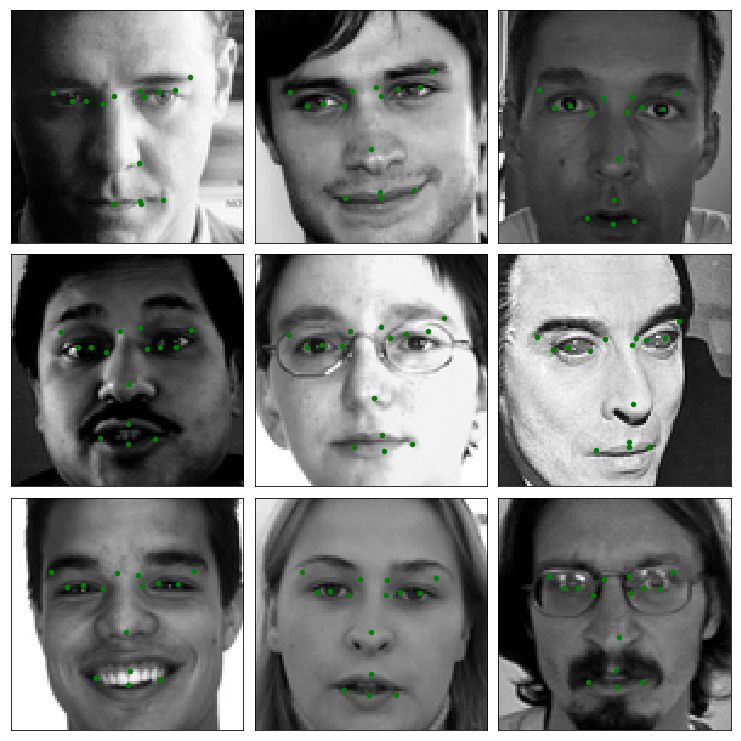

In [38]:
images = test_x[10:19]
points = model.predict(images.reshape(9, 96, 96, 1)) * 96

%matplotlib inline

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
  img = images[i]
  p = points[i]
  ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
  plt.imshow(np.squeeze(img), cmap="gray")
  plt.scatter(p[0::2], p[1::2], marker='o', color='green', s=20)

plt.show()